In [1]:
using Plots, Flux, LinearAlgebra, LaTeXStrings, Metal, ProgressMeter
using Flux: @functor
using Statistics: mean
using MLDatasets: MNIST
Flux.gpu_backend!("Metal")

# ResNetBlock
struct ResNetBlock
    conv1
    conv2
    skipconv
end

function ResNetBlock(in_channels::Int, out_channels::Int)
    ResNetBlock(
        Conv((3,3), in_channels => out_channels, pad=SamePad()),
        Conv((3,3), out_channels => out_channels, pad=SamePad()),
        Conv((1,1), in_channels => out_channels)
    )
end

function (m::ResNetBlock)(x::Array{Float32, 4})
    skip = m.skipconv(x)
    x = relu(m.conv1(x))
    x = m.conv2(x) + skip
    return relu(x)
end
@functor ResNetBlock

# ResNet
struct ResNetMNIST
    convs
    pool
    fc
end

function ResNetMNIST()
    conv1 = ResNetBlock(1, 64)
    conv2 = ResNetBlock(64, 128)
    conv3 = ResNetBlock(128, 256)
    pool = MaxPool((2,2), pad=SamePad())
    out_feat = 256 * 4 * 4
    fc = Dense(out_feat => 10)
    return ResNetMNIST(
        [conv1, conv2, conv3],
        pool,
        fc
    )
end

function (m::ResNetMNIST)(x::Array{Float32, 4})
    for conv in m.convs
        x = m.pool(conv(x))
    end
    bs = size(x, ndims(x))
    other = div(length(x), size(x,4))
    return m.fc(reshape(x, (other, bs)))
end
@functor ResNetMNIST

┌ Info: GPU backend is already set to: Metal.
│ No need to do anything else.
└ @ Flux /Users/lionelpeer/.julia/packages/Flux/CUn7U/src/functor.jl:207


In [ ]:
bs = 128
dataset = MNIST(:train)
dataloader = Flux.DataLoader(dataset, batchsize=bs, shuffle=true)

model = ResNetMNIST()
optim = Flux.setup(Flux.Adam(0.001), model)

epochs = 10
losses = []
@showprogress for epoch in 1:epochs
    for (i,x) in enumerate(dataloader)
        img = x.features
        img = reshape(img, (28, 28, 1, bs))
        target = x.targets
        target = Flux.onehotbatch(target, [i for i in 0:9])
        loss, grads = Flux.withgradient(model) do m
            pred = m(img)
            Flux.logitcrossentropy(pred, target)
        end
        Flux.update!(optim, model, grads[1])
        push!(losses, loss)
        end
    end
end

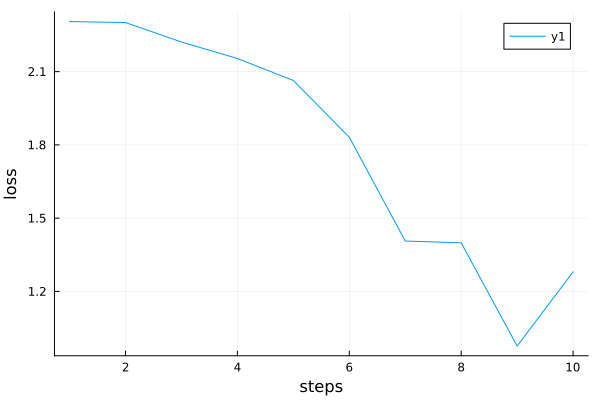

In [3]:
plot(losses, xlabel="steps", ylabel="loss", fmt=:png)